# Creating DataFrames for Each State

This file creates DataFrames for each state with 2020 Presidential Election Data and Total COVID-19 Cases as of mid-December.

In [1]:
# Imports - these are provided for you. Do not import any other packages.
import pandas as pd
import requests
import bs4
import time
from bs4 import BeautifulSoup

### Creating initial DataFrame with election data

Data for 2020 Presidential Election was scraped from https://abcnews.go.com/Elections/california-county-presidential-election-results-2020

In [2]:
# List of states to iterate through
state_list = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New-Hampshire','New-Jersey','New-Mexico','New-York','North-Carolina','North-Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode-Island','South-Carolina','South-Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West-Virginia','Wisconsin','Wyoming']

# Dictionary to store all DataFrames for each state
df_dictionary = {}

# Iterate through state list
for state in state_list:
    
    # Skip the special case
    if(state == 'Alaska'):
        continue
    
    # Create lists to hold county names, democrat votes and percent, republican votes and percent
    county_list, dem_per, dem_votes, rep_per, rep_votes = [], [], [], [], []
    
    # Build URL to scrape data about election
    election_page = 'https://abcnews.go.com/Elections/' + state.lower() + '-county-presidential-election-results-2020'
    page = requests.get(election_page).text
    soup = BeautifulSoup(page, 'html.parser')
    divs = soup.findAll('div', class_='CountyResults_result')
    
    # Temporary 1 second sleep timer to not overwhelm website with requests
    time.sleep(1)
    
    # Iterate through html and find data for each county
    for div in divs:
        
        # Save county name
        name = div.find('h2').text
        
        # Special case for named county in Louisiana
        if(state == 'Louisiana' and name == 'La Salle Parish'):
            name = 'LaSalle Parish';
        county_list.append(name)
    
        # Democrats info
        democrats = div.find('tr', class_='ElectionsTable__Row ResultsTable--counting ResultsTable__row--democrats')
        dems_vote = int(democrats.find('td', class_='ElectionsTable__Cell ResultsTable__votes').text.replace(',',''))
        dems_per = int(democrats.find('td', class_='ElectionsTable__Cell ResultsTable__percent').text.replace('%',''))
    
        # Append info scraped to lists
        dem_votes.append(dems_vote)
        dem_per.append(dems_per)

        # Republicans info
        republicans = div.find('tr', class_='ElectionsTable__Row ResultsTable--counting ResultsTable__row--republicans')
        reps_vote = int(republicans.find('td', class_='ElectionsTable__Cell ResultsTable__votes').text.replace(',',''))
        reps_per = int(republicans.find('td', class_='ElectionsTable__Cell ResultsTable__percent').text.replace('%',''))
    
        # Append info scraped to lists
        rep_votes.append(reps_vote)
        rep_per.append(reps_per)
    
    # Create DataFrames from lists for current state
    df = pd.DataFrame()
    df['County'] = county_list
    df['County Name'] = county_list
    df['Democrat Votes'] = dem_votes
    df['Democrat %'] = dem_per
    df['Republican Votes'] = rep_votes
    df['Republican %'] = rep_per
    df.set_index('County', inplace=True)
    
    # Save to dictionary with Key as state and Value as DataFrame
    df_dictionary[state] = df
    
    # print('Saving dataframe for ' + state)

### Appending population data to existing DataFrames

Data for Population was scrape from 
https://worldpopulationreview.com/us-counties/states/ca


In [3]:
# List of state abbreviations to iterate through
state_abrv = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

# Iterate through state list
for x in range(50):
    
    # Skip the special case
    if(state_abrv[x] == 'AK'):
        continue
    
    # Temporary 1 second sleep timer to not overwhelm website with requests
    time.sleep(1)
    
    # Build URL to scrape data about population
    population_page = 'https://worldpopulationreview.com/us-counties/states/' + state_abrv[x].lower()
    page = requests.get(population_page).text
    soup = BeautifulSoup(page, 'html.parser')
    table_pop = soup.findAll('tr')

    # Create lists to hold county names and population
    county_list, pop = [], []
    
    # Skip heading in population table
    heading = True
    
    # Iterate through html and find info for each county
    for row in table_pop:
        
        # Skip heading in table
        if heading:
            heading = False
            continue
    
        # Find each column in the row
        row = row.findAll('td')
    
        # Save county name
        county_name = row[0].find('a').text
        
        # Special case for Hawaii
        if state_abrv[x] == 'HI' and county_name == 'Kalawao County':
            continue
        
        # Special case for accented county in New Mexico
        elif state_abrv[x] == 'NM' and county_name == 'DoÃ±a Ana County':
            county_name = 'Dona Ana County'
        county_list.append(county_name)
    
        # Save population info
        pops = int(row[1].find(text=True).replace(',',''))
        pop.append(pops)

    # Create DataFrame for population for each county
    pops_df = pd.DataFrame()
    pops_df['County'] = county_list
    pops_df['Population'] = pop
    pops_df.set_index('County', inplace=True)
    
    # Combine population data to existing DataFrames with voter information
    df_dictionary[state_list[x]] = pd.concat([df_dictionary[state_list[x]],pops_df], axis=1, sort=True)
    # print('Adding population to ' + state_list[x])

### Appending population density data to existing DataFrames

They say most of a Data Scientist's time is spent cleaning the data... 
<br>
<sup>My sanity was tested during this portion.</sup>
<br>
Data for Population Density was scraped from http://www.usa.com/rank/california-state--population-density--county-rank.htm

In [4]:
# Iterate through state_list and state_abrv
for x in range(50):
   
    # Skip the special case
    if(state_abrv[x] == 'AK'):
        continue

    # Temporary 1 second sleep timer to not overwhelm website with requests
    time.sleep(1)
    
    # Build URL to scrape data about population density
    pop_density_url = 'http://www.usa.com/rank/' + state_list[x].lower() + '-state--population-density--county-rank.htm'
    page = requests.get(pop_density_url).text
    soup = BeautifulSoup(page, 'html.parser')
    
    # Grab the table from the website
    pop_dens_table = soup.findAll('table')
    rows = pop_dens_table[1].findAll('tr')

    # Create lists to hold county names and population
    county_list, pop_density = [], []

    # Skip heading in population table
    heading = True

    # Iterate through html and find info for each county
    for row in rows:
    
        # Skip heading in table
        if heading:
            heading = False
            continue
    
        # Find each column in the row
        content = row.findAll('td')
        
        # Save county name
        county = content[2].find('a').text.replace(', ' + state_abrv[x], ' County').replace('Saint', 'St.')
        
        # Special cases for many states...
        if state_list[x] == 'Alabama':
            if county == 'De Kalb County':
                county = 'DeKalb County'
        
        elif state_list[x] == 'Florida':
            if county == 'De Soto County':
                county = 'DeSoto County'

        elif state_list[x] == 'Georgia':
            if county == 'Dekalb County':
                county = 'DeKalb County'
            elif county == 'Mcduffie County':
                county = 'McDuffie County'
            elif county == 'Mcintosh County':
                county = 'McIntosh County'

        elif state_list[x] == 'Illinois':
            if county == 'Dekalb County':
                county = 'DeKalb County'
            elif county == 'Dewitt County':
                county = 'De Witt County'
            elif county == 'Dupage County':
                county = 'DuPage County'
            elif county == 'La Salle County':
                county = 'LaSalle County'
            elif county == 'Mcdonough County':
                county = 'McDonough County'
            elif county == 'Mchenry County':
                county = 'McHenry County'
            elif county == 'Mclean County':
                county = 'McLean County'
        
        elif state_list[x] == 'Indiana':
            if county == 'De Kalb County':
                county = 'DeKalb County'
            elif county == 'La Porte County':
                county = 'LaPorte County'
            elif county == 'Lagrange County':
                county = 'LaGrange County'
            elif county == 'St Joseph County':
                county = 'St. Joseph County'

        elif state_list[x] == 'Iowa':
            if county == 'Obrien County':
                county = 'O\'Brien County'
        
        elif state_list[x] == 'Kansas':
            if county == 'Mcpherson County':
                county = 'McPherson County'

        elif state_list[x] == 'Kentucky':
            if county == 'Mccracken County':
                county = 'McCracken County'
            elif county == 'Mccreary County':
                county = 'McCreary County'
            elif county == 'Mclean County':
                county = 'McLean County'
        
        elif state_list[x] == 'Louisiana':
            county = county.replace('County', 'Parish')
            if county == 'La Salle Parish':
                county = 'LaSalle Parish'
            elif county == 'St John The Baptist Parish':
                county = 'St. John the Baptist Parish'

        elif state_list[x] == 'Maryland':
            if county == 'Baltimore City County':
                county = 'Baltimore city'
            elif county == 'Prince Georges County':
                county = 'Prince George\'s County'
            elif county == 'Queen Annes County':
                county = 'Queen Anne\'s County'
            elif county == 'St. Marys County':
                county = 'St. Mary\'s County'
        
        elif state_list[x] == 'Minnesota':
            if county == 'Lac Qui Parle County':
                county = 'Lac qui Parle County'
            elif county == 'Lake Of The Woods County':
                county = 'Lake of the Woods County'
            elif county == 'Mcleod County':
                county = 'McLeod County'
        
        elif state_list[x] == 'Mississippi':
            if county == 'Desoto County':
                county = 'DeSoto County'
        
        elif state_list[x] == 'Missouri':
            if county == 'Dekalb County':
                county = 'DeKalb County'
            elif county == 'Mcdonald County':
                county = 'McDonald County'
            elif county == 'St. Louis City County':
                county = 'St. Louis city'
            elif county == 'St.e Genevieve County':
                county = 'Ste. Genevieve County'
        
        elif state_list[x] == 'Montana':
            if county == 'Lewis And Clark County':
                county = 'Lewis and Clark County'
            elif county == 'Mccone County':
                county = 'McCone County'
        
        elif state_list[x] == 'Nebraska':
            if county == 'Mcpherson County':
                county = 'McPherson County'
                
        elif state_list[x] == 'Nevada':
            if county == 'Carson City County':
                county = 'Carson City'
                
        elif state_list[x] == 'New-Mexico':
            if county == 'Mckinley County':
                county = 'McKinley County'
        
        elif state_list[x] == 'North-Carolina':
            if county == 'Mcdowell County':
                county = 'McDowell County'
        
        elif state_list[x] == 'North-Dakota':
            if county == 'Lamoure County':
                county = 'LaMoure County'
            elif county == 'Mchenry County':
                county = 'McHenry County'
            elif county == 'Mcintosh County':
                county = 'McIntosh County'
            elif county == 'Mckenzie County':
                county = 'McKenzie County'
            elif county == 'Mclean County':
                county = 'McLean County'
                
        elif state_list[x] == 'Oklahoma':
            if county == 'Mcclain County':
                county = 'McClain County'
            elif county == 'Mccurtain County':
                county = 'McCurtain County'
            elif county == 'Mcintosh County':
                county = 'McIntosh County'
                
        elif state_list[x] == 'Pennsylvania':
            if county == 'Mckean County':
                county = 'McKean County'
            
        elif state_list[x] == 'South-Carolina':
            if county == 'Mccormick County':
                county = 'McCormick County'
                
        elif state_list[x] == 'South-Dakota':
            if county == 'Mccook County':
                county = 'McCook County'
            elif county == 'Mcpherson County':
                county = 'McPherson County'
            elif county == 'Shannon County':
                county = 'Oglala Lakota County'
        
        elif state_list[x] == 'Tennessee':
            if county == 'Dekalb County':
                county = 'DeKalb County'
            elif county == 'Mcminn County':
                county = 'McMinn County'
            elif county == 'Mcnairy County':
                county = 'McNairy County'
                
        elif state_list[x] == 'Texas':
            if county == 'De Witt County':
                county = 'DeWitt County'
            elif county == 'Mcculloch County':
                county = 'McCulloch County'
            elif county == 'Mclennan County':
                county = 'McLennan County'
            elif county == 'Mcmullen County':
                county = 'McMullen County'

        elif state_list[x] == 'Virginia':
            county = county.replace('City County', 'city')
            if county == 'Bristol County':
                county = 'Bristol city'
            elif county == 'Charles city':
                county = 'Charles City County'
            elif county == 'Isle Of Wight County':
                county = 'Isle of Wight County'
            elif county == 'James city':
                county = 'James City County'
            elif county == 'King And Queen County':
                county = 'King and Queen County'
            elif county == 'Radford County':
                county = 'Radford city'
            elif county == 'Salem County':
                county = 'Salem city'
        
        elif state_list[x] == 'West-Virginia':
            if county == 'Mcdowell County':
                county = 'McDowell County'
                
        elif state_list[x] == 'Wisconsin':
            if county == 'Fond Du Lac County':
                county = 'Fond du Lac County'
        
        # Save density info
        density = float(content[1].text.replace(',', '').replace('/sq mi', ''))
    
        # Append saved info to lists
        county_list.append(county)
        pop_density.append(density)
    
    # Special case where density data was missing
    if state_list[x] == 'Virginia':
        county_list.append('Emporia city')
        pop_density.append(float(776.3))
    
    # Create DataFrame for population density for each county
    density_df = pd.DataFrame()
    density_df['County'] = county_list
    density_df['Population Density (per sq mi)'] = pop_density
    density_df.set_index('County', inplace=True)
    
    # Combine population density data to existing DataFrames with voter information
    df_dictionary[state_list[x]] = pd.concat([df_dictionary[state_list[x]], density_df], axis=1, sort=True)
    # print('Adding population density data to '+ state_list[x])

### Appending COVID-19 data to existing DataFrames 

Data for COVID-19 was scraped from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/california

In [5]:
# Iterate through list of states used earlier for election data
for state in state_list:
    
     # Temporary 1 second sleep timer to not overwhelm website with requests
    time.sleep(1)
    
    # Skip the special case
    if(state == 'Alaska'):
        continue
    
    # Build URL to scrape data about total COVID-19 cases 
    covid_page = 'https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/' + state.lower()
    page = requests.get(covid_page).text
    soup = BeautifulSoup(page, 'html.parser')
    covid_table = soup.find('tbody').findAll('tr')
    
    # Create list to save number of total cases in each county
    total_cases = []

    # Iterate through html and find info for each county
    for row in covid_table:
        
        # Save cases info
        cases = int(row.find('td').text.replace(',',''))
        total_cases.append(cases)
    
    # Special case for Hawaii
    if state == 'Hawaii':
        del total_cases[2]
    
    # Add new column 'Total COVID-19 Cases' to existing DataFrames for each state
    df_dictionary[state]['Total COVID-19 Cases'] = total_cases
    # print('Adding COVID-19 data to ' + state)

# Examples of DataFrames

Sanity checks

In [6]:
df_dictionary['New-Jersey']

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases
Atlantic County,Atlantic County,73808,53,64438,46,263351,409.8,10174
Bergen County,Bergen County,285967,58,204417,41,931588,3731.5,42008
Burlington County,Burlington County,154595,59,103345,39,445953,549.1,17812
Camden County,Camden County,175065,66,86207,33,506589,2255.4,24872
Cape May County,Cape May County,23941,41,33158,57,91632,155.2,2070
Cumberland County,Cumberland County,32742,52,28952,46,148419,232.3,6550
Essex County,Essex County,266820,77,75475,22,799380,6091.3,42666
Gloucester County,Gloucester County,86702,50,83340,48,291747,859.2,12052
Hudson County,Hudson County,181452,72,65698,26,672851,10509.5,38675
Hunterdon County,Hunterdon County,39457,47,43153,51,123935,289.7,3185


In [7]:
df_dictionary['California']

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases
Alameda County,Alameda County,617659,80,136309,18,1675900,1898.5,40262
Alpine County,Alpine County,476,64,244,33,1169,1.6,5
Amador County,Amador County,8153,36,13585,61,40099,61.3,823
Butte County,Butte County,50426,49,48730,48,208033,132.1,5765
Calaveras County,Calaveras County,10046,37,16518,61,46112,43.3,677
Colusa County,Colusa County,3234,41,4554,57,21676,18.5,1050
Contra Costa County,Contra Costa County,416386,72,152877,26,1156530,1345.2,33072
Del Norte County,Del Norte County,4677,41,6461,56,27884,22.8,605
El Dorado County,El Dorado County,51621,44,61838,53,194940,101.6,4412
Fresno County,Fresno County,193025,53,164464,45,1006250,157.8,49173


# Automating the creation of matching pairs of counties

### Helper method to apply on each row to find pairs
<br>
We consider a county to be a pair if it satisfies the following conditions:
<ol>
<li>The Population is between 0.7 and 1.3 times the original</li>
<li>The Population Density is between 0.4 and 1.6 times the original</li>
<li>The corresponding voting percentage is at least 60% or greater for the opposite party</li>
</ol>

In [8]:
def find_pairs(county, df):
    # Save relavant info on each county to find a similar pair
    dem_per = df.loc[county]['Democrat %']
    rep_per = df.loc[county]['Republican %']
    pop = df.loc[county]['Population']
    pop_dens = df.loc[county]['Population Density (per sq mi)']
    pairs = []
    
    # If it's a Democrat County, find a similar Republican County
    if dem_per >= 60:
        pairs = df.loc[ (df['Population'] > (pop * .7)) & (df['Population'] < (pop * 1.3)) & (df['Population Density (per sq mi)'] < (pop_dens * 1.6)) & (df['Population Density (per sq mi)'] > (pop_dens * 0.4)) & (df['Republican %'] > 60)]['County Name'].tolist()
    
    # If it's a Republican County, find a similar Democratic County
    elif rep_per >= 60:
        pairs = df.loc[ (df['Population'] > (pop * .7)) & (df['Population'] < (pop * 1.3)) & (df['Population Density (per sq mi)'] < (pop_dens * 1.6)) & (df['Population Density (per sq mi)'] > (pop_dens * 0.4)) & (df['Democrat %'] > 60)]['County Name'].tolist()
    
    # Return the found pairs as a list
    return pairs

### Apply the method

In [9]:
for state in state_list:
    if state == 'Alaska':
        continue
    df_dictionary[state]['Pairing County'] = df_dictionary[state]['County Name'].apply(find_pairs, df=df_dictionary[state])

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_dictionary['Georgia'])

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Appling County,Appling County,1784,21,6570,78,18246,36.0,1322,[]
Atkinson County,Atkinson County,825,26,2300,73,8068,24.1,568,[Hancock County]
Bacon County,Bacon County,625,13,4017,86,11196,39.2,706,"[Hancock County, Macon County]"
Baker County,Baker County,652,42,897,58,2990,9.6,116,[]
Baldwin County,Baldwin County,9140,50,8903,49,44887,171.5,2691,[]
Banks County,Banks County,932,11,7795,89,19496,78.3,980,[]
Barrow County,Barrow County,10453,28,26804,71,85646,435.0,4006,"[Dougherty County, Rockdale County]"
Bartow County,Bartow County,12091,24,37672,75,109098,214.4,5530,[Dougherty County]
Ben Hill County,Ben Hill County,2393,37,4111,63,16578,69.1,1095,[Macon County]
Berrien County,Berrien County,1269,16,6419,83,19528,41.7,685,[]


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_dictionary['California'])

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Alameda County,Alameda County,617659,80,136309,18,1675900,1898.5,40262,[]
Alpine County,Alpine County,476,64,244,33,1169,1.6,5,[]
Amador County,Amador County,8153,36,13585,61,40099,61.3,823,[]
Butte County,Butte County,50426,49,48730,48,208033,132.1,5765,[]
Calaveras County,Calaveras County,10046,37,16518,61,46112,43.3,677,[]
Colusa County,Colusa County,3234,41,4554,57,21676,18.5,1050,[]
Contra Costa County,Contra Costa County,416386,72,152877,26,1156530,1345.2,33072,[]
Del Norte County,Del Norte County,4677,41,6461,56,27884,22.8,605,[]
El Dorado County,El Dorado County,51621,44,61838,53,194940,101.6,4412,[]
Fresno County,Fresno County,193025,53,164464,45,1006250,157.8,49173,[]


In [13]:
import babypandas as bpd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np

import otter
import numbers
import IPython

### Red State: Florida    (A Red state is a state where most of the people in the state supports republican)

In [14]:
#Load the DataFrame for Florida
Florida = df_dictionary['Florida']
Florida

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Alachua County,Alachua County,89704,63,50972,36,269235,259.9,14468,"[Charlotte County, Clay County, Hernando Count..."
Baker County,Baker County,2037,15,11911,85,30067,45.9,2246,[]
Bay County,Bay County,25614,28,66097,71,163170,167.4,10295,[]
Bradford County,Bradford County,3160,23,10334,76,28650,91.7,1674,[]
Brevard County,Brevard County,148549,41,207883,58,608681,352.5,18511,[]
...,...,...,...,...,...,...,...,...,...
Union County,Union County,1053,17,5133,82,15146,61.1,1342,[]
Volusia County,Volusia County,130575,43,173821,57,560467,348.3,19334,[]
Wakulla County,Wakulla County,5351,29,12874,70,35065,42.2,1852,[]
Walton County,Walton County,10338,24,32947,75,77410,46.6,4320,[]


***First Pair: Palm Beach County( Dem) & Pasco County (Rep)***

In [18]:
Flopair01 = Florida[(Florida.get('County Name') == 'Palm Beach County' ) | (Florida.get('County Name') == 'Pasco County' )]
Flopair01

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Palm Beach County,Palm Beach County,433572,56,334711,43,1510660,570.3,74789,[]
Pasco County,Pasco County,119073,39,179621,60,568804,544.4,18733,[]


Text(0.5, 0, 'Total COVID-19 Cases')

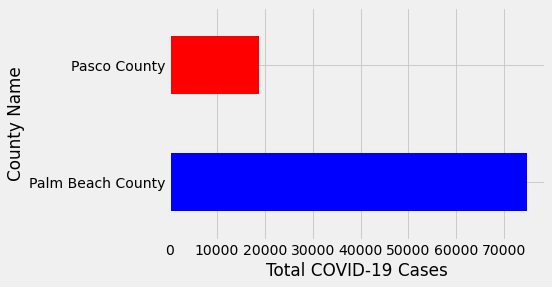

In [20]:
ax = Flopair01.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [21]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Flopair01.get('Total COVID-19 Cases').iloc[0] - Flopair01.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is 56056 . Therefore, Republican is having a good influence to the control of Covid spreading.


***Second pair: Alachua County( Dem) & Lake County (Rep)***

In [22]:
Flopair02 = Florida[(Florida.get('County Name') == 'Alachua County' ) | (Florida.get('County Name') == 'Lake County' )]
Flopair02

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Alachua County,Alachua County,89704,63,50972,36,269235,259.9,14468,"[Charlotte County, Clay County, Hernando Count..."
Lake County,Lake County,83505,40,125859,60,377516,263.6,12966,"[Alachua County, Leon County]"


Text(0.5, 0, 'Total COVID-19 Cases')

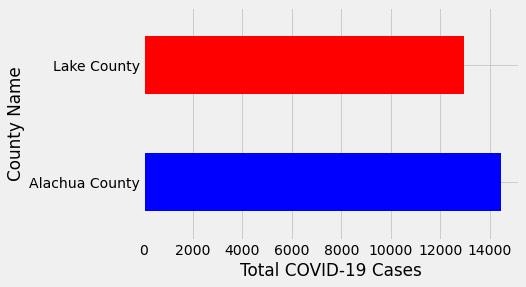

In [25]:
ax = Flopair02.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [26]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Flopair02.get('Total COVID-19 Cases').iloc[0] - Flopair02.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is 1502 . Therefore, Republican is having a good influence to the control of Covid spreading.


***Third pair: Gadsden County( Dem) & Jackson County (Rep)***

In [27]:
Flopair03 = Florida[(Florida.get('County Name') == 'Jackson County' ) | (Florida.get('County Name') == 'Gadsden County' )]
Flopair03

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Gadsden County,Gadsden County,16153,68,7465,31,45393,88.7,3577,"[DeSoto County, Jackson County, Okeechobee Cou..."
Jackson County,Jackson County,6766,30,15488,69,44716,51.4,4268,[]


Text(0.5, 0, 'Total COVID-19 Cases')

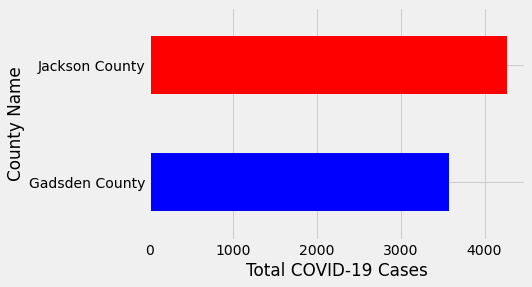

In [37]:
ax = Flopair03.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [29]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Flopair03.get('Total COVID-19 Cases').iloc[0] - Flopair03.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a bad influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is -691 . Therefore, Republican is having a bad influence to the control of Covid spreading.


***However, we noticed that these selected samples are seemed to be biased towards Republican. Therefore, we will be conducting an A|B test to the dataset.***

In [30]:
# Getting the Florida mean dem.total cases - mean rep.total cases
FloObservedDifferece = (Florida[Florida.get('Democrat %') > Florida.get('Republican %')].get('Total COVID-19 Cases').mean()) - (Florida[Florida.get('Republican %') > Florida.get('Democrat %')].get('Total COVID-19 Cases').mean())
FloObservedDifferece

56602.548484848485

In [31]:
#set up the bootstrap
n_repetitions = 5000
FloDifferences = np.array([])
for i in np.arange(n_repetitions):
    FloShuffled = np.random.permutation(Florida.get('Total COVID-19 Cases'))
    FloShuffledTable = Florida.assign(Shuffled_cases = FloShuffled)
    FloDifferences = np.append(FloDifferences, ((FloShuffledTable[FloShuffledTable.get('Democrat %') > FloShuffledTable.get('Republican %')].get('Shuffled_cases').mean()) - (FloShuffledTable[FloShuffledTable.get('Democrat %') < FloShuffledTable.get('Republican %')].get('Shuffled_cases').mean())))
bpd.DataFrame().assign(Difference = FloDifferences).plot(kind = 'hist', density = True)
plt.scatter(FloObservedDifferece, 0, color ='red', s = 40)

NameError: name 'bpd' is not defined

We can conclude that counties that supports Trump/ Republican ACTUALLY have a higher Total COVID cases.

### Blue State: California    (A Blue state is a state where most of the people in the state supports Democratic)

In [41]:
#Load data for California
California = df_dictionary['California']
California

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Alameda County,Alameda County,617659,80,136309,18,1675900,1898.5,40262,[]
Alpine County,Alpine County,476,64,244,33,1169,1.6,5,[]
Amador County,Amador County,8153,36,13585,61,40099,61.3,823,[]
Butte County,Butte County,50426,49,48730,48,208033,132.1,5765,[]
Calaveras County,Calaveras County,10046,37,16518,61,46112,43.3,677,[]
Colusa County,Colusa County,3234,41,4554,57,21676,18.5,1050,[]
Contra Costa County,Contra Costa County,416386,72,152877,26,1156530,1345.2,33072,[]
Del Norte County,Del Norte County,4677,41,6461,56,27884,22.8,605,[]
El Dorado County,El Dorado County,51621,44,61838,53,194940,101.6,4412,[]
Fresno County,Fresno County,193025,53,164464,45,1006250,157.8,49173,[]


***First pair: Sonoma County( Dem) & Placer County (Rep)***

In [92]:
Calpair01 = California[(California.get('County Name') == 'Sonoma County' ) | (California.get('County Name') == 'Placer County' )]
Calpair01.sort_values(by = 'Democrat %', ascending = False)
Calpair01

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Placer County,Placer County,106869,46,122488,52,404328,240.6,10554,[]
Sonoma County,Sonoma County,199938,75,61825,23,490029,278.2,15702,[]


Text(0.5, 0, 'Total COVID-19 Cases')

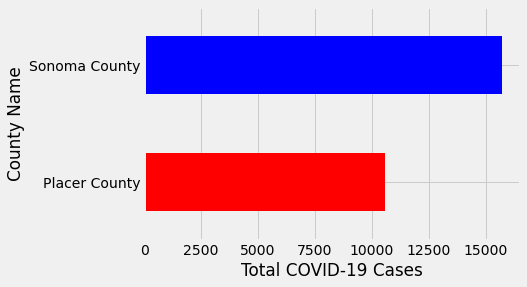

In [93]:
ax = Calpair01.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['red', 'blue'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [94]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Calpair01.get('Total COVID-19 Cases').iloc[0] - Calpair01.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is -5148 . Therefore, Republican is having a good influence to the control of Covid spreading.


***Second pair: Fresno County( Dem) & Sutter County (Rep)***

In [86]:
Calpair02 = California[(California.get('County Name') == 'Fresno County' ) | (California.get('County Name') == 'Sutter County' )]
Calpair02

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Fresno County,Fresno County,193025,53,164464,45,1006250,157.8,49173,[]
Sutter County,Sutter County,17367,41,24375,57,97594,156.2,5369,[]


Text(0.5, 0, 'Total COVID-19 Cases')

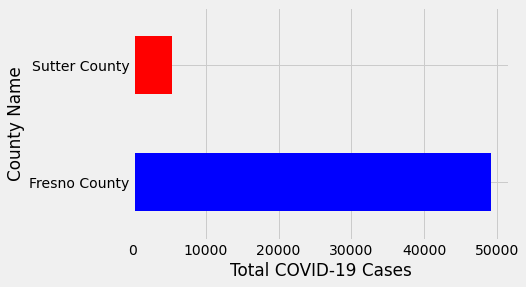

In [87]:
ax = Calpair02.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [88]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Calpair02.get('Total COVID-19 Cases').iloc[0] - Calpair02.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is 43804 . Therefore, Republican is having a good influence to the control of Covid spreading.


***Third pair: Santa Barbara County( Dem) & Yuba County(Rep)***

In [89]:
Calpair03 = California[(California.get('County Name') == 'Santa Barbara County' ) | (California.get('County Name') == 'Yuba County' )]
Calpair03 

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Santa Barbara County,Santa Barbara County,129963,65,65736,33,447218,113.9,14190,[]
Yuba County,Yuba County,11230,38,17676,59,79779,113.5,3212,[]


Text(0.5, 0, 'Total COVID-19 Cases')

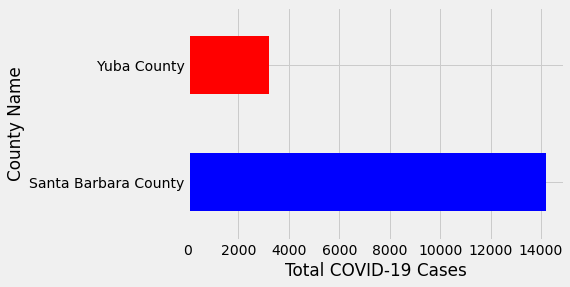

In [90]:
ax = Calpair03.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [91]:
frames2 = [Calpair01, Calpair02, Calpair03]
result2 = pd.concat(frames2)
result2

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Placer County,Placer County,106869,46,122488,52,404328,240.6,10554,[]
Sonoma County,Sonoma County,199938,75,61825,23,490029,278.2,15702,[]
Fresno County,Fresno County,193025,53,164464,45,1006250,157.8,49173,[]
Sutter County,Sutter County,17367,41,24375,57,97594,156.2,5369,[]
Santa Barbara County,Santa Barbara County,129963,65,65736,33,447218,113.9,14190,[]
Yuba County,Yuba County,11230,38,17676,59,79779,113.5,3212,[]


In [65]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Calpair03.get('Total COVID-19 Cases').iloc[0] - Calpair03.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is 10978 . Therefore, Republican is having a good influence to the control of Covid spreading.


In [66]:
CalObservedDifference= (California[California.get('Democrat %') > California.get('Republican %')].get('Total COVID-19 Cases').mean() )- (California[California.get('Democrat %') < California.get('Republican %')].get('Total COVID-19 Cases').mean())
CalObservedDifference

40368.086956521736

In [67]:
CalDifferences = np.array([])
for i in np.arange(n_repetitions):
    CalShuffled= np.random.permutation(California.get('Total COVID-19 Cases'))
    CalShuffledTable = California.assign(Shuffled_cases = CalShuffled)
    CalDifferences = np.append(CalDifferences, ((CalShuffledTable[CalShuffledTable.get('Democrat %') > CalShuffledTable.get('Republican %')].get('Shuffled_cases').mean()) - (CalShuffledTable[CalShuffledTable.get('Democrat %') < CalShuffledTable.get('Republican %')].get('Shuffled_cases').mean())))
bpd.DataFrame().assign(Difference = CalDifferences).plot(kind = 'hist', density = True)
plt.scatter(CalObservedDifference, 0, color ='red', s = 40)

KeyboardInterrupt: 

### Swing State: Georgia    (A Swing state is a state where people are about uniformly supporting both parties)

In [69]:
#Load the DataFrame for Georgia
Georgia = df_dictionary['Georgia']
Georgia

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Appling County,Appling County,1784,21,6570,78,18246,36.0,1322,[]
Atkinson County,Atkinson County,825,26,2300,73,8068,24.1,568,[Hancock County]
Bacon County,Bacon County,625,13,4017,86,11196,39.2,706,"[Hancock County, Macon County]"
Baker County,Baker County,652,42,897,58,2990,9.6,116,[]
Baldwin County,Baldwin County,9140,50,8903,49,44887,171.5,2691,[]
...,...,...,...,...,...,...,...,...,...
Whitfield County,Whitfield County,10680,29,25644,70,105007,354.3,9424,[Dougherty County]
Wilcox County,Wilcox County,861,26,2402,73,8443,23.7,329,[Hancock County]
Wilkes County,Wilkes County,2160,43,2823,56,9690,21.4,410,[]
Wilkinson County,Wilkinson County,2074,44,2665,56,8865,20.9,466,[]


***First pair: Barrow County( Dem) & Chatham County(Rep)***

In [70]:
Geopair01 = Georgia[(Georgia.get('County Name') == 'Chatham County' ) | (Georgia.get('County Name') == 'Barrow County' )]
Geopair01.sort_values(by = 'Democrat %')

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Barrow County,Barrow County,10453,28,26804,71,85646,435.0,4006,"[Dougherty County, Rockdale County]"
Chatham County,Chatham County,78247,59,53232,40,289694,435.4,11718,[]


Text(0.5, 0, 'Total COVID-19 Cases')

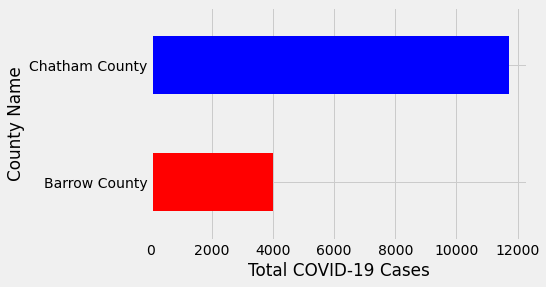

In [73]:
ax = Geopair01.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['red', 'blue'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [74]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Geopair01.get('Total COVID-19 Cases').iloc[0] - Geopair01.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a bad influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is -7712 . Therefore, Republican is having a bad influence to the control of Covid spreading.


***Second pair: Newton County( Dem) & Whitfield County(Rep)***

In [75]:
Geopair02 = Georgia[(Georgia.get('County Name') == 'Newton County' ) | (Georgia.get('County Name') == 'Whitfield County' )]
Geopair02

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Newton County,Newton County,29789,55,23869,44,114067,363.6,4044,[]
Whitfield County,Whitfield County,10680,29,25644,70,105007,354.3,9424,[Dougherty County]


Text(0.5, 0, 'Total COVID-19 Cases')

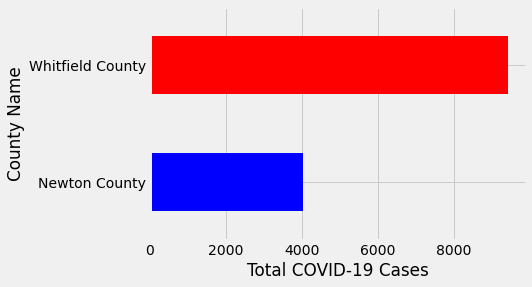

In [96]:
ax = Geopair02.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [78]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Geopair02.get('Total COVID-19 Cases').iloc[0] - Geopair02.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a bad influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is -5380 . Therefore, Republican is having a bad influence to the control of Covid spreading.


***Third pair: Liberty County( Dem) & Lumpkin County(Rep)***

In [79]:
Geopair03 = Georgia[(Georgia.get('County Name') == 'Liberty County' ) | (Georgia.get('County Name') == 'Lumpkin County' )]
Geopair03

,County Name,Democrat Votes,Democrat %,Republican Votes,Republican %,Population,Population Density (per sq mi),Total COVID-19 Cases,Pairing County
Liberty County,Liberty County,13104,61,7959,37,62264,107.0,1648,"[Camden County, Colquitt County, Effingham Cou..."
Lumpkin County,Lumpkin County,3126,20,12163,78,34321,108.1,1575,[]


Text(0.5, 0, 'Total COVID-19 Cases')

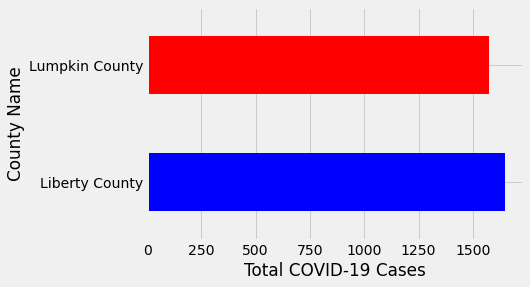

In [100]:
ax = Geopair03.plot.barh(x = 'County Name', y = 'Total COVID-19 Cases', color = ['blue', 'red'], legend = None)
ax.set_xlabel("Total COVID-19 Cases")

In [101]:
print('The total COVID-19 Cases differences between Democratic and Republican is', Geopair03.get('Total COVID-19 Cases').iloc[0] - Geopair03.get('Total COVID-19 Cases').iloc[1],'. Therefore, Republican is having a good influence to the control of Covid spreading.')

The total COVID-19 Cases differences between Democratic and Republican is 73 . Therefore, Republican is having a good influence to the control of Covid spreading.


In [102]:
GeoObservedDifference= (Georgia[Georgia.get('Democrat %') > Georgia.get('Republican %')].get('Total COVID-19 Cases').mean() )- (Georgia[Georgia.get('Democrat %') < Georgia.get('Republican %')].get('Total COVID-19 Cases').mean())
GeoObservedDifference

6455.783720930233

In [103]:
GeoDifferences = np.array([])
for i in np.arange(n_repetitions):
    GeoShuffled= np.random.permutation(Georgia.get('Total COVID-19 Cases'))
    GeoShuffledTable = Georgia.assign(Shuffled_cases = GeoShuffled)
    GeoDifferences = np.append(GeoDifferences, ((GeoShuffledTable[GeoShuffledTable.get('Democrat %') > GeoShuffledTable.get('Republican %')].get('Shuffled_cases').mean()) - (GeoShuffledTable[GeoShuffledTable.get('Democrat %') < GeoShuffledTable.get('Republican %')].get('Shuffled_cases').mean())))
bpd.DataFrame().assign(Difference = GeoDifferences).plot(kind = 'hist', density = True)
plt.scatter(GeoObservedDifference, 0, color ='red', s = 40)

NameError: name 'bpd' is not defined

# Export DataFrames as CSV files for analysis

In [ ]:
#for state in state_list:
#    if state == 'Alaska':
#        continue
#    df_dictionary[state].to_csv(state + '_csv')
    